In [1]:
import pandas as pd 
import gensim
from gensim import corpora, models
from gensim.models import Phrases


In [2]:
text_list=[]
def create_token(tweet) :
  tweet=tweet.split()
  text_list.append(tweet)

In [4]:
raw_data=pd.read_csv('src\cleaned_km.csv')

In [6]:
raw_data['full_text'] = raw_data['full_text'].astype(str)

In [7]:
raw_data['full_text'].apply(create_token)

0        None
1        None
2        None
3        None
4        None
         ... 
27238    None
27239    None
27240    None
27241    None
27242    None
Name: full_text, Length: 27243, dtype: object

In [8]:
text_list[0]

['suka',
 'bikin',
 'gaduh',
 'lebih',
 'orang',
 'teken',
 'petisi',
 'ui',
 'pecat',
 'adek',
 'armando',
 'sejak',
 'dulu',
 'tak',
 'patut',
 'dosen',
 'sering',
 'lontar',
 'narasi']

In [9]:
bigram = Phrases(text_list, min_count=10)
trigram = Phrases(bigram[text_list])

In [10]:
for idx in range(len(text_list)):
    for token in bigram[text_list[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            text_list[idx].append(token)
    for token in trigram[text_list[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            text_list[idx].append(token)

In [11]:
dictionary = corpora.Dictionary(text_list)
dictionary.filter_extremes(no_below=5, no_above=0.2)

In [12]:
print(dictionary)

Dictionary<7514 unique tokens: ['adek', 'bikin', 'bikin_gaduh', 'dosen', 'dulu']...>


In [13]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in text_list]

In [14]:
tfidf = models.TfidfModel(doc_term_matrix) #build TF-IDF model
corpus_tfidf = tfidf[doc_term_matrix]

In [15]:
for i in corpus_tfidf :
    print(i)
    break

[(0, 0.25908660671426725), (1, 0.16511646530802943), (2, 0.3295557481442403), (3, 0.15145363163608236), (4, 0.16877821132053603), (5, 0.30487729515935286), (6, 0.14190961235652233), (7, 0.3080682565254191), (8, 0.15623910163141547), (9, 0.2821321050740382), (10, 0.29418275418227974), (11, 0.23891711066643054), (12, 0.21339089326327673), (13, 0.23608856756833463), (14, 0.214966819202153), (15, 0.18068663080890957), (16, 0.26896677752706744), (17, 0.19358663783632585)]


# buat time_slice

In [16]:
raw_data['created_at'] = pd.to_datetime(raw_data['created_at'])

In [17]:
# pick the data with year 2019
num_19 = len(raw_data[raw_data['created_at'].dt.year == 2019])

def slice_num_data(year):
    num = []
    num.append(len(raw_data.loc[(raw_data['created_at'].dt.year == year) & (raw_data['created_at'].dt.month < 4)]))
    num.append(len(raw_data.loc[(raw_data['created_at'].dt.year == year) & (raw_data['created_at'].dt.month > 3) & (raw_data['created_at'].dt.month < 7)]))
    num.append(len(raw_data.loc[(raw_data['created_at'].dt.year == year) & (raw_data['created_at'].dt.month > 6) & (raw_data['created_at'].dt.month < 10)]))
    num.append(len(raw_data.loc[(raw_data['created_at'].dt.year == year) & (raw_data['created_at'].dt.month > 9)]))
    return num

In [18]:
# make splitted data for 2019 - 2024
num_20 = slice_num_data(2020)
num_21 = slice_num_data(2021)
num_22 = slice_num_data(2022)
num_23 = slice_num_data(2023)
num_24 = slice_num_data(2024)
# make a list of data
num_data = [num_19]
num_data = num_data + num_20 + num_21 + num_22 + num_23 + num_24
num_data.remove(0)
num_data.remove(0)
print(num_data)

[52, 1345, 619, 1190, 730, 1084, 1688, 2767, 1646, 1527, 931, 2492, 1806, 1600, 1613, 1855, 2022, 1950, 326]


# modeling

In [19]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.ldaseqmodel import LdaSeqModel
from tqdm import tqdm

In [27]:
model = LdaSeqModel(corpus=corpus_tfidf,
                                 id2word=dictionary,
                                 time_slice=num_data,
                                 num_topics=9)

c:\ProgramData\anaconda3\Lib\site-packages\gensim\models\ldaseqmodel.py:1480: RuntimeWarning: invalid value encountered in scalar divide
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
c:\ProgramData\anaconda3\Lib\site-packages\gensim\models\ldaseqmodel.py:298: RuntimeWarning: divide by zero encountered in scalar divide
  convergence = np.fabs((bound - old_bound) / old_bound)
c:\ProgramData\anaconda3\Lib\site-packages\gensim\models\ldaseqmodel.py:1480: RuntimeWarning: invalid value encountered in scalar divide
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
c:\ProgramData\anaconda3\Lib\site-packages\gensim\models\ldaseqmodel.py:1480: RuntimeWarning: invalid value encountered in scalar divide
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
c:\ProgramData\anaconda3\Lib\site-packages\gensim\models\ldaseqmodel.py:1480: RuntimeWarning: invalid value encountered in scalar divide
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total)

In [29]:
model.save('dlda_km.model')

In [30]:
from gensim.models.coherencemodel import CoherenceModel
# import pickle

coh_score_km_9 = [CoherenceModel(topics=model.dtm_coherence(time=i), corpus=corpus_tfidf, 
                dictionary=dictionary, coherence='u_mass').get_coherence() 
 for i in range(len(num_data))]

In [31]:
print(coh_score_km_9)

[-9.319266093099062, -9.316700151481212, -9.342537432984633, -9.18111962462722, -9.040644575831536, -9.238480722249667, -9.218762415448587, -9.303578772972621, -9.345355348953658, -9.376383902051636, -9.483626997681197, -9.294090824929205, -9.367126995052898, -9.61126311004627, -9.644804093789443, -9.686712687422235, -9.804797567661977, -9.743493308876802, -9.73999603121081]


In [32]:
coh_c_v = [CoherenceModel(topics=model.dtm_coherence(time=i), corpus=corpus_tfidf, 
                dictionary=dictionary, texts = text_list, coherence='c_v').get_coherence() 
 for i in range(len(num_data))]

In [33]:
coh_c_v

[0.4280511297948237,
 0.4280511297948237,
 0.42788077484570847,
 0.42248457339203016,
 0.42576216613728673,
 0.42746988281119375,
 0.42610351889742787,
 0.4282279983317083,
 0.4268425263812169,
 0.4276761899435316,
 0.42002118196782734,
 0.42839644461953363,
 0.43713867994501704,
 0.43993597526753697,
 0.44366451290688114,
 0.4466205488871955,
 0.43885615108941134,
 0.4398921379779065,
 0.4398921379779065]

# Coherence Score

In [35]:
coh_c_v = [CoherenceModel(topics=model.dtm_coherence(time=i), corpus=corpus_tfidf, 
                dictionary=dictionary, texts = text_list, coherence='c_v').get_coherence() 
 for i in range(len(num_data))]

coh_u_mass = [CoherenceModel(topics=model.dtm_coherence(time=i), corpus=corpus_tfidf, 
                dictionary=dictionary, coherence='u_mass').get_coherence() 
 for i in range(len(num_data))]

coh_score_km_9 = [coh_c_v, coh_u_mass]

In [37]:
coh_score = pd.DataFrame({'U_Mass Score': coh_u_mass, 'C_V Score': coh_c_v})
coh_score.head()

,U_Mass Score,C_V Score
0,-9.319266,0.428051
1,-9.316700,0.428051
2,-9.342537,0.427881
3,-9.181120,0.422485
4,-9.040645,0.425762


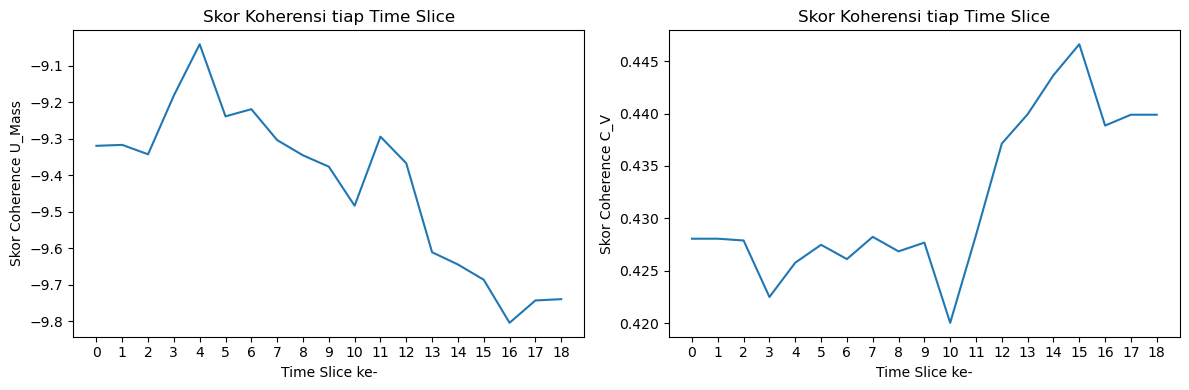

In [38]:
import matplotlib.pyplot as plt
x = range(0, len(coh_score))

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(x, coh_score['U_Mass Score'])
plt.title('Skor Koherensi tiap Time Slice')
plt.xlabel("Time Slice ke-")
plt.ylabel("Skor Coherence U_Mass")
plt.xticks(x)

plt.subplot(1,2,2)
plt.plot(x, coh_score['C_V Score'])
plt.title('Skor Koherensi tiap Time Slice')
plt.xlabel("Time Slice ke-")
plt.ylabel("Skor Coherence C_V")
plt.xticks(x)

plt.tight_layout()
plt.show()

In [39]:
coh_score.to_csv('coh_score_km_9.csv')

## Tes

In [24]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step), desc="Topics Progress"): #range(start, limit, step):
        model = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics, iterations=100, passes=10, workers=15) 
        # model = LdaSeqModel(corpus=corpus,
        #                          id2word=dictionary,
        #                          time_slice=num_data,
        #                          num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [25]:
start=1
limit=50
step=1
model_list, coherence_values = compute_coherence_values(dictionary, corpus=corpus_tfidf,
                                                        texts=text_list, start=start, limit=limit, step=step)

Topics Progress: 100%|██████████| 49/49 [30:29<00:00, 37.34s/it]


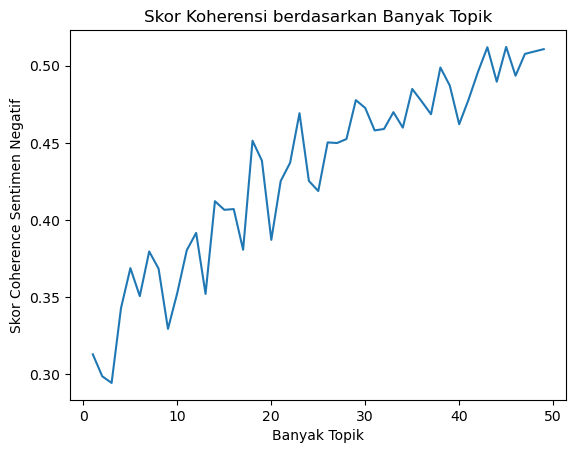

In [26]:
import matplotlib.pyplot as plt
x = range(start, limit, step)

plt.figure()
plt.plot(x, coherence_values)
plt.title('Skor Koherensi berdasarkan Banyak Topik')
plt.xlabel("Banyak Topik")
plt.ylabel("Skor Coherence Sentimen Negatif")
# plt.savefig('lda-cores15-91K-50.jpg')
plt.show()

In [25]:
temp=0
index=0
for i in range(49):
    if coherence_values[i]>temp:
        temp=coherence_values[i]
        index=i+1
print(f'Koherensi tertinggi dicapai pada {index} topik dengan nilai {temp}')

Koherensi tertinggi dicapai pada 11 topik dengan nilai 0.44642411539817567


In [26]:
coherence_values[10]

0.44642411539817567

In [73]:
model_list[33].save('lda_91K_15c.model')

In [74]:
for idx, topic in model_list[33].print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.025*"kasus_positif" + 0.010*"thailand" + 0.009*"taman" + 0.007*"traveling" + 0.006*"per_hari" + 0.006*"keluar_rumah" + 0.006*"longsor" + 0.005*"hutan" + 0.005*"masa_psbb" + 0.005*"kasus"
Topic: 1 Word: 0.026*"wabah_corona" + 0.025*"imbas_corona" + 0.011*"corona" + 0.010*"tembus_rp" + 0.009*"wabah" + 0.008*"imbas" + 0.008*"orang_kaya" + 0.007*"virus_corona" + 0.007*"bicara_soal" + 0.007*"pariwisata"
Topic: 2 Word: 0.015*"anggota_dpr" + 0.013*"hand_sanitizer" + 0.010*"anggota_dprd" + 0.008*"anggota" + 0.008*"pemkot" + 0.008*"tingkat_mati" + 0.007*"meghan_markle" + 0.007*"karen_pooroe" + 0.007*"pangeran_harry" + 0.006*"jalan_rapid"
Topic: 3 Word: 0.016*"tengah_wabah" + 0.009*"walkot" + 0.008*"jakbar" + 0.007*"banjir" + 0.007*"tangerang" + 0.006*"korupsi" + 0.006*"kapolda" + 0.006*"seluruh" + 0.006*"banjir_jakarta" + 0.005*"duga_korupsi"
Topic: 4 Word: 0.073*"virus_corona" + 0.034*"new_normal" + 0.024*"virus" + 0.015*"corona" + 0.014*"minta_maaf" + 0.011*"normal" + 0.011*"